# Exploratory Data Analysis - Predictive Maintenance

This notebook performs exploratory analysis on the NASA C-MAPSS turbofan engine dataset.

## Contents:
1. Data Loading
2. Dataset Overview
3. Sensor Degradation Analysis
4. RUL Distribution
5. Correlation Analysis
6. Feature Engineering Preview

In [1]:
# Dependency Check and Installation
# Run this cell FIRST before any other cells

import sys
import os
from pathlib import Path

# First, install missing dependencies directly in the notebook's Python environment
print("Checking and installing dependencies...")
import subprocess

# Install required packages in the current Python environment
packages = [
    'pyyaml',
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'xgboost',
    'scipy',
    'statsmodels',
    'tqdm',
    'requests',
    'plotly',
    'shap'
]

for package in packages:
    try:
        __import__(package.replace('-', '_').split('[')[0])
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"  [OK] {package} installed")

print("\n[OK] All dependencies are installed!")

# Add parent directory to path so we can import from src/
notebook_path = Path().resolve()
project_root = notebook_path.parent if notebook_path.name == 'notebooks' else notebook_path

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"[OK] Project root: {project_root}")
print(f"[OK] Python version: {sys.version.split()[0]}")
print(f"[OK] Ready to proceed!")

Checking and installing dependencies...
Installing pyyaml...
  [OK] pyyaml installed
Installing scikit-learn...
  [OK] scikit-learn installed


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[OK] All dependencies are installed!
[OK] Project root: D:\Projects\Predictive Maintenance for IoT Sensors
[OK] Python version: 3.11.9
[OK] Ready to proceed!


In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.config_loader import load_config
from src.utils.logger import get_logger
from src.ingestion.data_loader import get_data_loader
from src.preprocessing import FeatureEngineer
from src.visualization import PredictiveMaintenanceVisualizer

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Data

In [3]:
# Load configuration
config = load_config()

print("Project:", config['project']['name'])
print("Random Seed:", config['project']['seed'])

Project: predictive-maintenance-iot
Random Seed: 42


In [4]:
# Load NASA C-MAPSS dataset
loader = get_data_loader('cmapss', config)

# Load FD001 subset (single operating condition, single fault mode)
train_df, test_df, rul_df = loader.load_dataset('FD001')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"RUL data shape: {rul_df.shape}")

2025-10-03 12:07:02,907 - src.ingestion.data_loader - INFO - Loading C-MAPSS FD001 dataset
2025-10-03 12:07:03,170 - src.ingestion.data_loader - INFO - Loaded FD001: Train shape=(20631, 26), Test shape=(13096, 26)
Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)


## 2. Dataset Overview

In [5]:
# Display first few rows
print("\nTraining Data Sample:")
train_df.head(10)


Training Data Sample:


,unit_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774
7,1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106
8,1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066
9,1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694


In [6]:
# Basic statistics
print("\nDataset Statistics:")
print(f"Number of engines: {train_df['unit_id'].nunique()}")
print(f"Total cycles: {len(train_df)}")
print(f"Average cycles per engine: {train_df.groupby('unit_id')['cycle'].max().mean():.2f}")
print(f"Min cycles: {train_df.groupby('unit_id')['cycle'].max().min()}")
print(f"Max cycles: {train_df.groupby('unit_id')['cycle'].max().max()}")


Dataset Statistics:
Number of engines: 100
Total cycles: 20631
Average cycles per engine: 206.31
Min cycles: 128
Max cycles: 362


In [7]:
# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum().sum())


Missing Values:
0


In [8]:
# Sensor columns
sensor_cols = [col for col in train_df.columns if col.startswith('sensor_')]
print(f"\nNumber of sensors: {len(sensor_cols)}")
print(f"Sensors: {sensor_cols}")


Number of sensors: 21
Sensors: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


## 3. Add RUL Labels

In [9]:
# Add RUL to training data
train_df = loader.add_rul_column(train_df)
train_df = loader.add_labels(train_df, w1=30, w0=15)

print("\nTraining data with RUL:")
train_df[['unit_id', 'cycle', 'RUL', 'label_binary', 'RUL_clipped']].head(10)


Training data with RUL:


,unit_id,cycle,RUL,label_binary,RUL_clipped
0,1,1,191,0,15
1,1,2,190,0,15
2,1,3,189,0,15
3,1,4,188,0,15
4,1,5,187,0,15
5,1,6,186,0,15
6,1,7,185,0,15
7,1,8,184,0,15
8,1,9,183,0,15
9,1,10,182,0,15


## 4. Sensor Degradation Visualization

In [10]:
# Initialize visualizer
viz = PredictiveMaintenanceVisualizer(config, '../results')

# Plot sensor degradation for first 3 units
viz.plot_sensor_degradation(train_df, sensor_cols, unit_ids=[1, 2, 3])

2025-10-03 12:07:43,772 - src.visualization.plots - INFO - Plotting sensor degradation
2025-10-03 12:07:45,568 - src.visualization.plots - INFO - Plot saved to ..\results\sensor_degradation.png


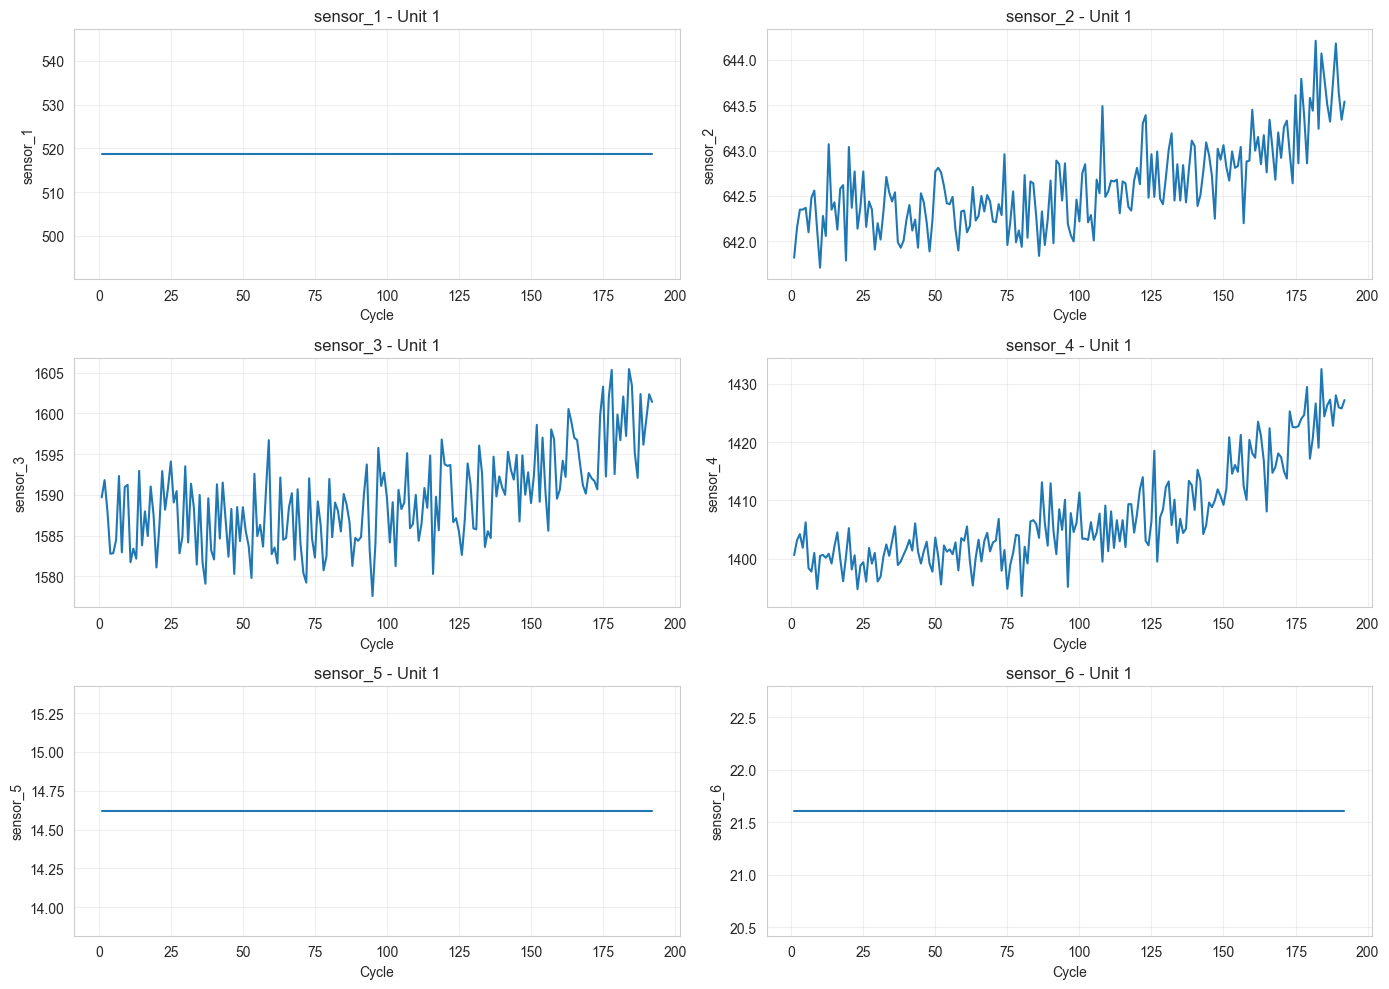

In [11]:
# Plot specific sensors for one unit
unit_1_data = train_df[train_df['unit_id'] == 1]

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, sensor in enumerate(sensor_cols[:6]):
    axes[idx].plot(unit_1_data['cycle'], unit_1_data[sensor])
    axes[idx].set_xlabel('Cycle')
    axes[idx].set_ylabel(sensor)
    axes[idx].set_title(f'{sensor} - Unit 1')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. RUL Distribution Analysis

In [12]:
# Plot RUL distribution
viz.plot_rul_distribution(train_df)

2025-10-03 12:07:55,111 - src.visualization.plots - INFO - Plotting RUL distribution
2025-10-03 12:07:55,856 - src.visualization.plots - INFO - Plot saved to ..\results\rul_distribution.png


In [13]:
# RUL statistics
print("\nRUL Statistics:")
print(train_df['RUL'].describe())

print("\nLabel distribution:")
print(train_df['label_binary'].value_counts())
print(f"\nFailure ratio: {train_df['label_binary'].mean():.2%}")


RUL Statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

Label distribution:
label_binary
0    17531
1     3100
Name: count, dtype: int64

Failure ratio: 15.03%


## 6. Correlation Analysis

In [14]:
# Correlation with RUL
correlations = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

print("\nTop 10 sensors correlated with RUL:")
print(correlations.head(10))

print("\nBottom 10 sensors correlated with RUL:")
print(correlations.tail(10))


Top 10 sensors correlated with RUL:
sensor_12    0.671983
sensor_7     0.657223
sensor_21    0.635662
sensor_20    0.629428
sensor_6    -0.128348
sensor_14   -0.306769
sensor_9    -0.390102
sensor_13   -0.562569
sensor_8    -0.563968
sensor_3    -0.584520
Name: RUL, dtype: float64

Bottom 10 sensors correlated with RUL:
sensor_2    -0.606484
sensor_15   -0.642667
sensor_4    -0.678948
sensor_11   -0.696228
sensor_1          NaN
sensor_5          NaN
sensor_10         NaN
sensor_16         NaN
sensor_18         NaN
sensor_19         NaN
Name: RUL, dtype: float64


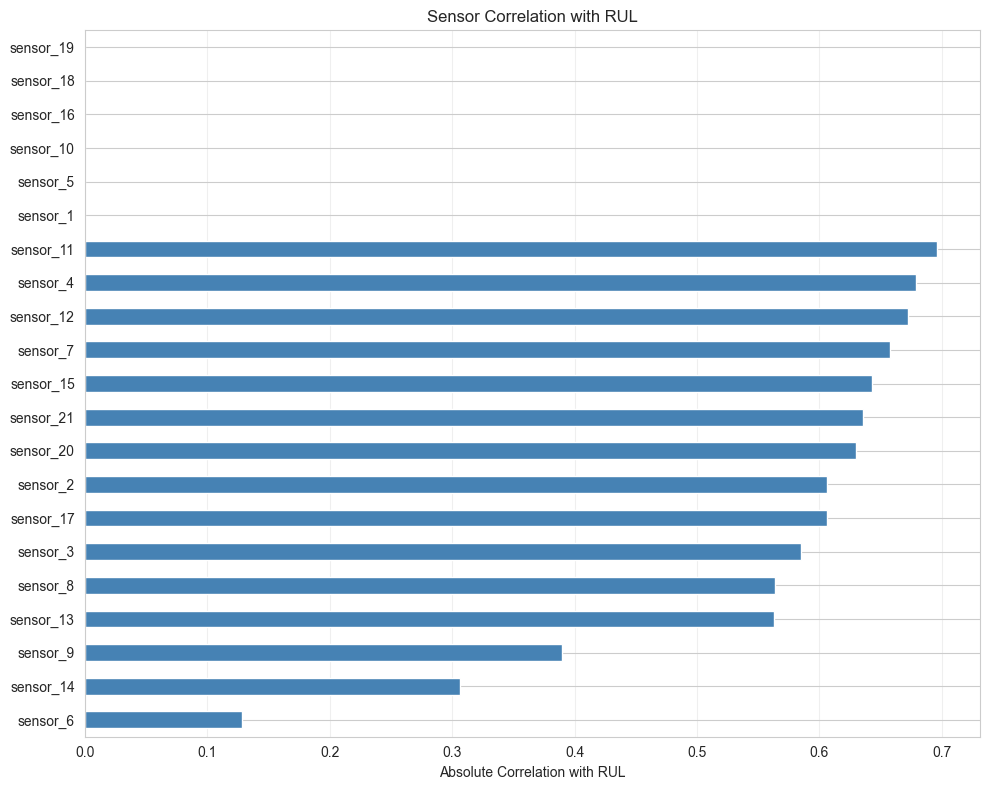

In [15]:
# Visualize correlation with RUL
fig, ax = plt.subplots(figsize=(10, 8))

correlations_sorted = correlations.abs().sort_values(ascending=True)
correlations_sorted.plot(kind='barh', ax=ax, color='steelblue')

ax.set_xlabel('Absolute Correlation with RUL')
ax.set_title('Sensor Correlation with RUL')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

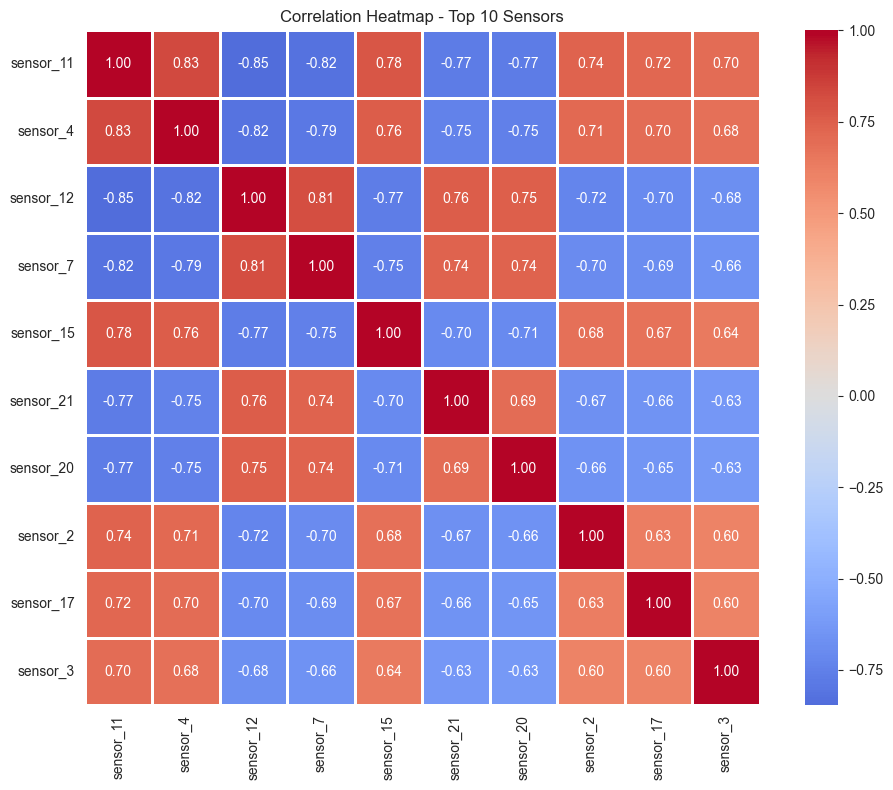

In [16]:
# Correlation heatmap (selected sensors)
top_sensors = correlations.abs().sort_values(ascending=False).head(10).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_sensors].corr(), annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Heatmap - Top 10 Sensors')
plt.tight_layout()
plt.show()

## 7. Operating Settings Analysis

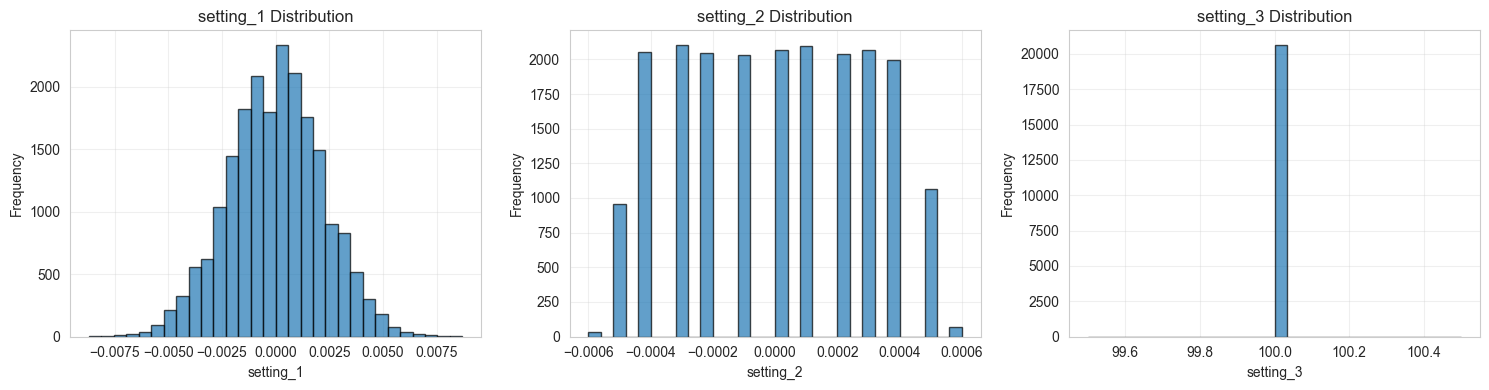

In [17]:
# Operating settings distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, setting in enumerate(['setting_1', 'setting_2', 'setting_3']):
    axes[idx].hist(train_df[setting], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(setting)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{setting} Distribution')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Engineering Preview

In [18]:
# Create feature engineer
engineer = FeatureEngineer(config)

# Create features for a subset
sample_df = train_df[train_df['unit_id'].isin([1, 2, 3])].copy()
sample_features = engineer.create_all_features(sample_df, sensor_cols)

print(f"\nOriginal features: {sample_df.shape[1]}")
print(f"Engineered features: {sample_features.shape[1]}")
print(f"Added features: {sample_features.shape[1] - sample_df.shape[1]}")

2025-10-03 12:08:15,677 - src.preprocessing.feature_engineering - INFO - Creating all features
2025-10-03 12:08:15,679 - src.preprocessing.feature_engineering - INFO - Creating rolling features with window size 30
2025-10-03 12:08:15,796 - src.preprocessing.feature_engineering - INFO - Created rolling features. New shape: (658, 134)
2025-10-03 12:08:15,800 - src.preprocessing.feature_engineering - INFO - Creating advanced statistical features
2025-10-03 12:08:28,265 - src.preprocessing.feature_engineering - INFO - Created statistical features. New shape: (658, 176)
2025-10-03 12:08:28,267 - src.preprocessing.feature_engineering - INFO - Creating degradation features
2025-10-03 12:08:28,370 - src.preprocessing.feature_engineering - INFO - Created degradation features. New shape: (658, 239)
2025-10-03 12:08:28,372 - src.preprocessing.feature_engineering - INFO - All features created. Final shape: (658, 239)

Original features: 29
Engineered features: 239
Added features: 210


In [19]:
# Display new feature columns
new_cols = [col for col in sample_features.columns if col not in sample_df.columns]
print(f"\nSample of new features ({len(new_cols)} total):")
print(new_cols[:20])


Sample of new features (210 total):
['sensor_1_rolling_mean', 'sensor_1_rolling_std', 'sensor_1_rolling_min', 'sensor_1_rolling_max', 'sensor_1_rolling_rms', 'sensor_2_rolling_mean', 'sensor_2_rolling_std', 'sensor_2_rolling_min', 'sensor_2_rolling_max', 'sensor_2_rolling_rms', 'sensor_3_rolling_mean', 'sensor_3_rolling_std', 'sensor_3_rolling_min', 'sensor_3_rolling_max', 'sensor_3_rolling_rms', 'sensor_4_rolling_mean', 'sensor_4_rolling_std', 'sensor_4_rolling_min', 'sensor_4_rolling_max', 'sensor_4_rolling_rms']


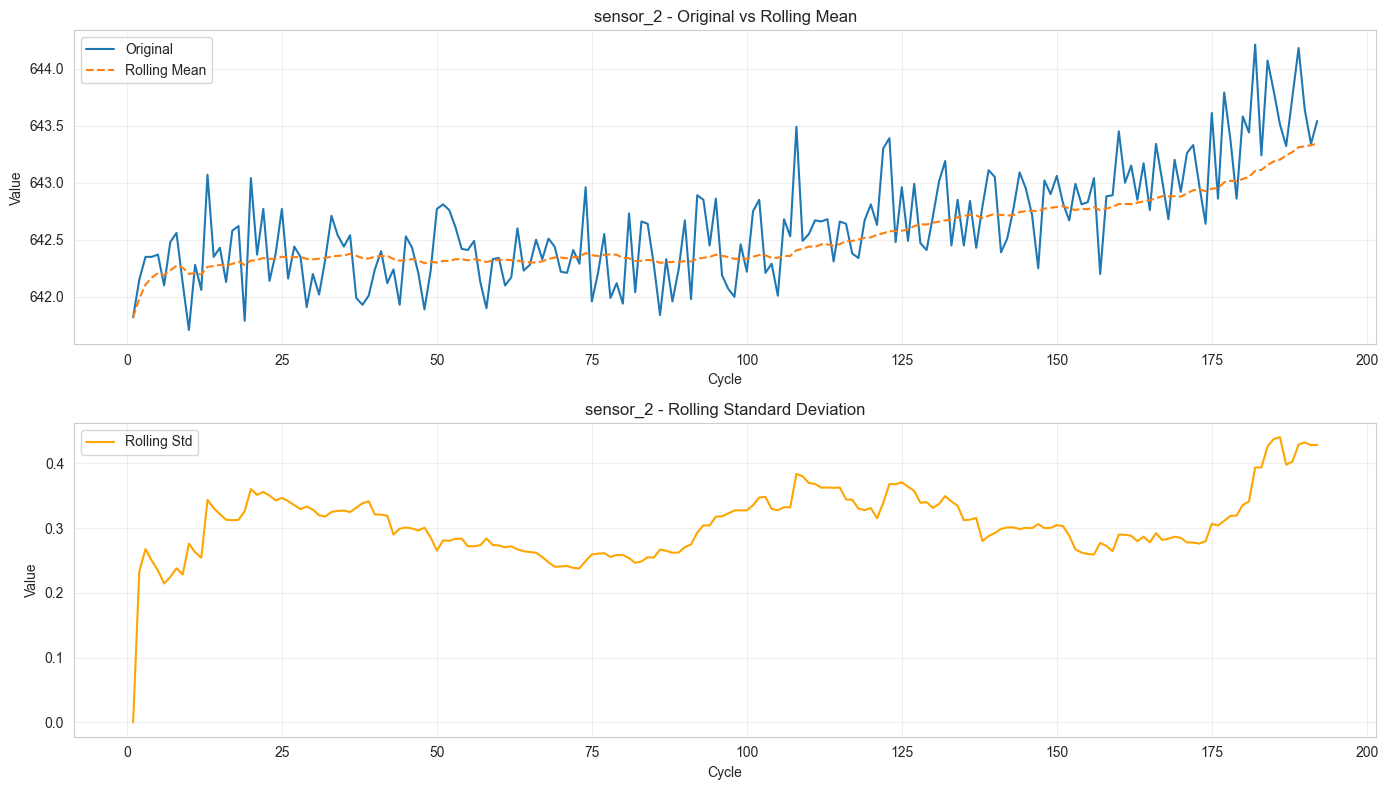

In [20]:
# Compare original vs rolling features
unit_1_features = sample_features[sample_features['unit_id'] == 1]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

sensor = 'sensor_2'

axes[0].plot(unit_1_features['cycle'], unit_1_features[sensor], label='Original')
axes[0].plot(unit_1_features['cycle'], unit_1_features[f'{sensor}_rolling_mean'], 
             label='Rolling Mean', linestyle='--')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Value')
axes[0].set_title(f'{sensor} - Original vs Rolling Mean')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(unit_1_features['cycle'], unit_1_features[f'{sensor}_rolling_std'], 
             label='Rolling Std', color='orange')
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Value')
axes[1].set_title(f'{sensor} - Rolling Standard Deviation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary

### Key Findings:
1. **Dataset**: 100 training engines with varying operational cycles
2. **Sensors**: 21 sensors with different correlation strengths to RUL
3. **RUL Distribution**: Right-skewed with most engines having low RUL values
4. **Feature Engineering**: Successfully created rolling statistics and degradation features
5. **Next Steps**: 
   - Build baseline models (Random Forest, XGBoost)
   - Train deep learning models (LSTM, GRU, CNN)
   - Compare model performance